In [3]:
import matplotlib.pyplot as plt
import numpy as np
import math
!pip install emcee
import emcee
!pip install corner
import corner
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import WMAP9 as cosmo
from astropy.io import fits as pyfits
import pandas as pd

     |████████████████████████████████| 51kB 3.0MB/s 


La estimación de la distancia con SNe Ia está basada en que estos eventos forman una clase homogénea que tiene una variabilidad calculable los parámetros de dilatación temporal de la curva de luz y el color de la supernova la máximo brillo. Se asume que las supernovas con color, forma y entorno galáctico igual tienen en promedio la misma luminosidad intínseca para todos los corrimientos al rojo. La cuantificacion por medio de un modelo lineal nos da un módulo de distancia estnadarizado $\mu = 5 log_{10}(d_{L}/10 pc)$:

# $\mu = m_{B}^{\star} - (M_{B} - \alpha \times X_{1} + \beta \times C)$

con $m_{B}^{\star}$ siendo el pico de la magnitud de la banda $B$, $X_{1}$ es la extensión de la curvatura de luz,  $M_{B}$, $\alpha$ y $\beta$ son parámetros de ajuste a determinar y $C$ es el color de la supernova en su brillo máximo.
Podremos obtener el módulo de la distancia si encontramos la distancia luminosa, que se obtiene conociendo el corrimiento al rojo.

In [4]:
import os
print(os.listdir("."))

['.config', 'sample_data']


In [5]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.23-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [6]:
!mkdir -p drive
!google-drive-ocamlfuse drive -o nonempty

In [ ]:
print(os.listdir("drive/Colab/"))
os.chdir("drive/Colab/")
print(os.listdir("."))

In [8]:
data = np.loadtxt('data/jla_lcparams.txt', usecols = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19))

In [9]:
z = np.zeros(740)
m_b = np.zeros(740)
err_m_b = np.zeros(740)
x_1 = np.zeros(740)
err_x_1 = np.zeros(740)
C = np.zeros(740)
err_C = np.zeros(740)

masa_estelar = np.zeros(740)
conjunto = np.zeros(740)


for i in range(740):
    z[i] = data[i][0]
    m_b[i] = data[i][3]
    err_m_b[i] = data[i][4]
    x_1[i] = data[i][5]
    err_x_1[i] = data[i][6]
    C[i] = data[i][7]
    err_C[i] = data[i][8]

    masa_estelar[i] = data[i][9]
    conjunto[i] = data[i][16]

In [10]:
err_total = np.zeros(740)
par_masa = np.zeros(740)

a = np.zeros((740, 2220))
n = np.zeros ((2220, 1))
delta_k = np.zeros((740, 2220, 3))


masa_aux = np.ones(740)
diagonal1 = np.zeros((740, 740))
diagonal2 = np.zeros((740, 740))
diagonal3 = np.zeros((740, 740))


for i in range(740):
    err_aux = err_m_b[i]**2 + err_x_1[i]**2 + err_C[i]**2
    err_total[i] = err_aux

    if masa_estelar[i] >= 10:
        par_masa[i] = 1
    else:
        par_masa[i] = 0


In [11]:
c_n = pyfits.open('covmat/C_stat.fits')['PRIMARY'].data + pyfits.open('covmat/C_cal.fits')['PRIMARY'].data + pyfits.open('covmat/C_model.fits')['PRIMARY'].data + pyfits.open('covmat/C_bias.fits')['PRIMARY'].data + pyfits.open('covmat/C_host.fits')['PRIMARY'].data + pyfits.open('covmat/C_dust.fits')['PRIMARY'].data + pyfits.open('covmat/C_pecvel.fits')['PRIMARY'].data + pyfits.open('covmat/C_nonia.fits')['PRIMARY'].data

In [12]:
def Log_LH(Theta):
    Om, A, B, masa, delta = Theta

    for i in range(740):
        for j in range(2220):
            a[i][j] = delta_k[i][j][0] + A*delta_k[i][j][1] + B*delta_k[i][j][2]  
    a_trans = np.transpose(a)    


    Om = abs(Om)
    d_l = FlatLambdaCDM(H0 = 70, Om0 = Om, Tcmb0 = 2.725).luminosity_distance(z)
    model = np.matmul(a, n) - (masa*masa_aux).reshape(740, 1) + (delta*par_masa).reshape(740, 1)

    mu_stand = np.zeros(740)
    for i in range(740):

        mu_stand[i] = 5*math.log10(d_l[i].value/10e-6)


    LH_aux = model - mu_stand.reshape(740, 1)  
    LH_aux_trans = np.transpose(LH_aux)

    c_cov = np.matmul(np.matmul(a, c_n), a_trans) + diagonal1 + diagonal2 + diagonal3
    c_cov_inv = np.linalg.inv(c_cov)


    return np.matmul(np.matmul(LH_aux_trans, c_cov_inv), LH_aux)



def Log_LH_1(Theta, m_b, par_masa, x_1, C, z, err_total):
    Om, A, B, masa, delta = Theta
    model = m_b - (masa + delta*par_masa - A*x_1 + B*C)
    Om = abs(Om)
    d_l = FlatLambdaCDM(H0 = 70, Om0 = Om, Tcmb0 = 2.725).luminosity_distance(z)
    mu_stand = np.zeros(740)
    for i in range(740):
        mu_stand[i] = 5*math.log10(d_l[i].value/10e-6)
    return -0.5 * np.sum((mu_stand - model) ** 2 / err_total + np.log(err_total))


def Log_prior(Theta):
    Om, A, B, masa, delta = Theta
    if 0.0 < Om < 1.0 and 0.0 < A < 1.0 and 3 < B < 4 and -20 < masa < -19 and -1.0 < delta < 0.0:
        prior = 0
    else:
        prior = -np.inf
    return prior

def Log_probability(Theta):
    log_p = Log_prior(Theta)
    if not np.isfinite(log_p):
        return -np.inf
    return log_p + Log_LH(Theta)



def Log_probability_1(Theta, m_b, par_masa, x_1, C, z, err_total):
    lp = Log_prior(Theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + Log_LH_1(Theta, m_b, par_masa, x_1, C, z, err_total)

In [49]:
pos = [0.3, 0.15, 3.0, -19.0, -0.0070] + 1e-4 * np.random.randn(10, 5)
nwalkers, ndim = pos.shape

sampler_model = emcee.EnsembleSampler(nwalkers, ndim, Log_probability_1, args=(m_b, par_masa, x_1, C, z, err_total))
sampler_model.run_mcmc(pos, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [07:49<00:00, 10.65it/s]


In [52]:
flat_samples = sampler_model.get_chain(discard=100, thin=15, flat=True)    #flat=True
print(flat_samples.shape)

(3260, 5)


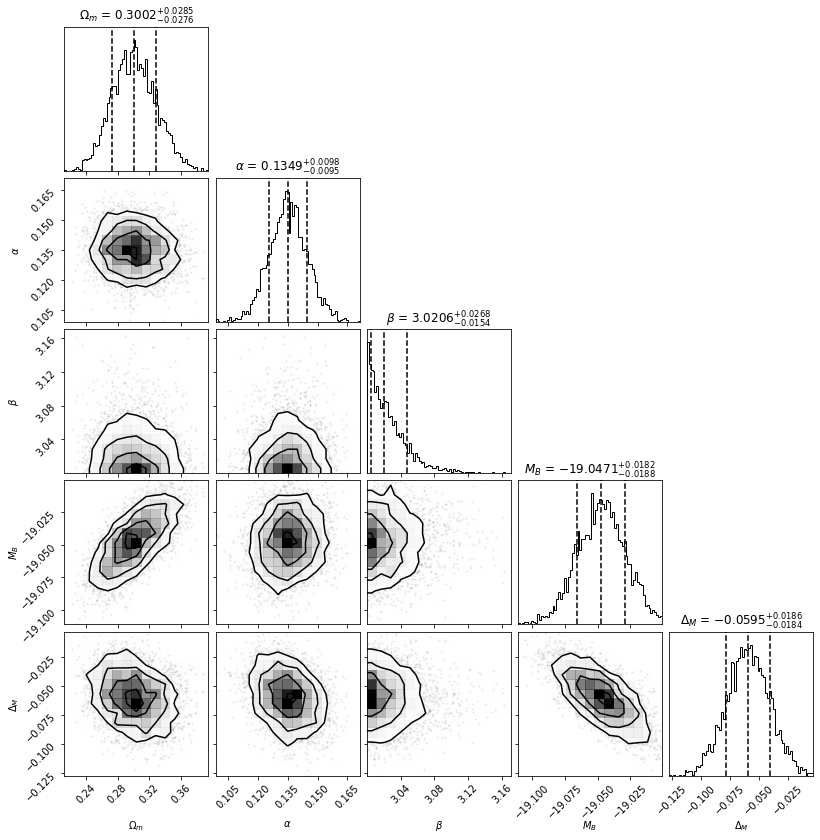

In [53]:
fig = corner.corner(
    flat_samples,
    bins = 15,
    hist_bin_factor = 5,
    labels=[r"$\Omega_m$", r"$\alpha$", r"$\beta$", r"$M_{B}$", r"$\Delta_M$"],
    quantiles = [0.16, 0.5, 0.84],
    title_fmt = '.4f',
    show_titles = True, title_kwargs={"fontsize": 12}
);

In [54]:
from IPython.display import display, Math
labels = [r"\Omega_m", r"\alpha",r"\beta",r"M_{B}",r"\Delta_M"]
res = np.zeros(ndim)
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    res[i] = mcmc[1]
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Text(0, 0.5, '$\\mu = m_{B}^{*} - (M_{B} - \\alpha \\times X_{1} + \\beta \\times C)$')

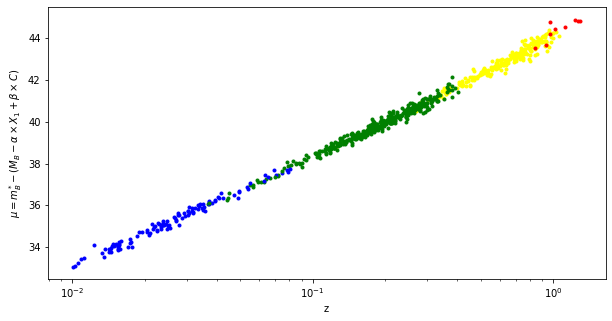

In [55]:
plt.figure(figsize=(10,5))
for i in range(740):
    if conjunto[i] == 3:
        plt.plot(z[i], m_b[i] - (res[3] + res[4]*par_masa[i] - res[1]*x_1[i] + res[2]*C[i]), '.', color = 'blue')
    elif conjunto[i] == 1:
        plt.plot(z[i], m_b[i] - (res[3] + res[4]*par_masa[i] - res[1]*x_1[i] + res[2]*C[i]), '.', color = 'yellow')
    elif conjunto[i] == 2:
        plt.plot(z[i], m_b[i] - (res[3] + res[4]*par_masa[i] - res[1]*x_1[i] + res[2]*C[i]), '.', color = 'green')
    else:
        plt.plot(z[i], m_b[i] - (res[3] + res[4]*par_masa[i] - res[1]*x_1[i] + res[2]*C[i]), '.', color = 'red')

plt.xscale('log')
plt.xlabel('z')
plt.ylabel(r'$\mu = m_{B}^{*} - (M_{B} - \alpha \times X_{1} + \beta \times C)$')

Ahora con inferencia de parámetros

In [13]:
for i in range(740):
    n[3*i] = m_b[i]
    n[3*i + 1] = x_1[i]
    n[3*i + 2] = C[i]

    for j in range(2220):
        for k in range(3):
            if 3*i == j + k:
                delta_k[i][j][k] = 1
            else:
                delta_k[i][j][k] = 0

    for j in range(740):
        if i == j:
          
            diagonal1[i][j] = ((0.0025)/(z[i]*math.log(10)))**2
            diagonal2[i][j] = (0.055*z[i])**2
            
            if conjunto[i] == 3:
                diagonal3[i][j] = (0.12)**2
            elif conjunto[i] == 1:
                diagonal3[i][j] = (0.11)**2
            elif conjunto[i] == 2:
                diagonal3[i][j] = (0.08)**2
            else:
                diagonal3[i][j] = (0.11)**2

In [31]:
pos_i = [0.5, 0.5, 3.5, -19.5, -0.5] + 0.01*np.random.randn(10, 5)
nwalkers, ndim = pos_i.shape

#cambiamos la funcion de log probability
sampler = emcee.EnsembleSampler(nwalkers, ndim, Log_probability)
sampler.run_mcmc(pos_i, 900, progress=True);

100%|██████████| 900/900 [8:33:52<00:00, 34.26s/it]


In [ ]:

flat_samples = sampler.get_chain(discard=1, thin=1, flat=True)    #flat=True
fig = corner.corner(
    flat_samples,
    bins = 50,
    hist_bin_factor = 5,
    labels=[r"$\Omega_m$", r"$\alpha$", r"$\beta$", r"$M_{B}$", r"$\Delta_M$"],
    quantiles = [0.16, 0.5, 0.84],
    title_fmt = '.4f',
    show_titles = True, title_kwargs={"fontsize": 12}
    

);

## Imagen anterior para 900 incluida en el anexo

In [50]:
from IPython.display import display, Math
labels = [r"\Omega_m", r"\alpha",r"\beta",r"M_{B}",r"\Delta_M"]
res = np.zeros(ndim)
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    res[i] = mcmc[1]
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Text(0, 0.5, '$\\mu = m_{B}^{*} - (M_{B} - \\alpha \\times X_{1} + \\beta \\times C)$')

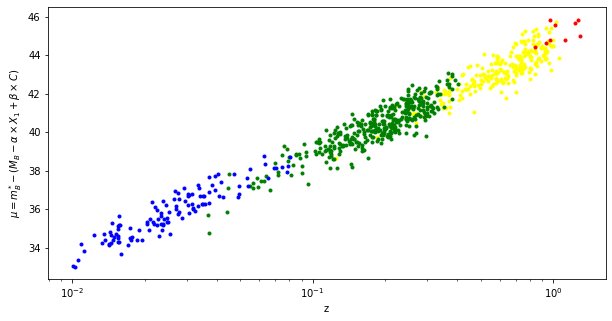

In [51]:
plt.figure(figsize=(10,5))
for i in range(740):
    if conjunto[i] == 3:
        plt.plot(z[i], m_b[i] - (res[3] + res[4]*par_masa[i] - res[1]*x_1[i] + res[2]*C[i]), '.', color = 'blue')
    elif conjunto[i] == 1:
        plt.plot(z[i], m_b[i] - (res[3] + res[4]*par_masa[i] - res[1]*x_1[i] + res[2]*C[i]), '.', color = 'yellow')
    elif conjunto[i] == 2:
        plt.plot(z[i], m_b[i] - (res[3] + res[4]*par_masa[i] - res[1]*x_1[i] + res[2]*C[i]), '.', color = 'green')
    else:
        plt.plot(z[i], m_b[i] - (res[3] + res[4]*par_masa[i] - res[1]*x_1[i] + res[2]*C[i]), '.', color = 'red')
#plt.plot(datos_ord['z'], datos_ord['mu_stand'], '-', color = 'black');
plt.xscale('log')
plt.xlabel('z')
plt.ylabel(r'$\mu = m_{B}^{*} - (M_{B} - \alpha \times X_{1} + \beta \times C)$')

In [ ]:
#falló el proceso
pos_i2 = [0.3, 0.3, 3.3, -19.3, -0.3] + 0.001*np.random.randn(10, 5)
nwalkers2, ndim2 = pos_i2.shape

sampler2 = emcee.EnsembleSampler(nwalkers2, ndim2, Log_probability)
sampler2.run_mcmc(pos_i2, 1500, progress=True);

 73%|███████▎  | 1096/1500 [8:34:50<3:08:18, 27.97s/it]

Nuevo intento con 1200

In [14]:
pos_i2 = [0.3, 0.3, 3.3, -19.3, -0.3] + 0.001*np.random.randn(10, 5)
nwalkers2, ndim2 = pos_i2.shape

sampler2 = emcee.EnsembleSampler(nwalkers2, ndim2, Log_probability)
sampler2.run_mcmc(pos_i2, 1200, progress=True);

100%|██████████| 1200/1200 [10:08:47<00:00, 30.44s/it]


### Gráficas

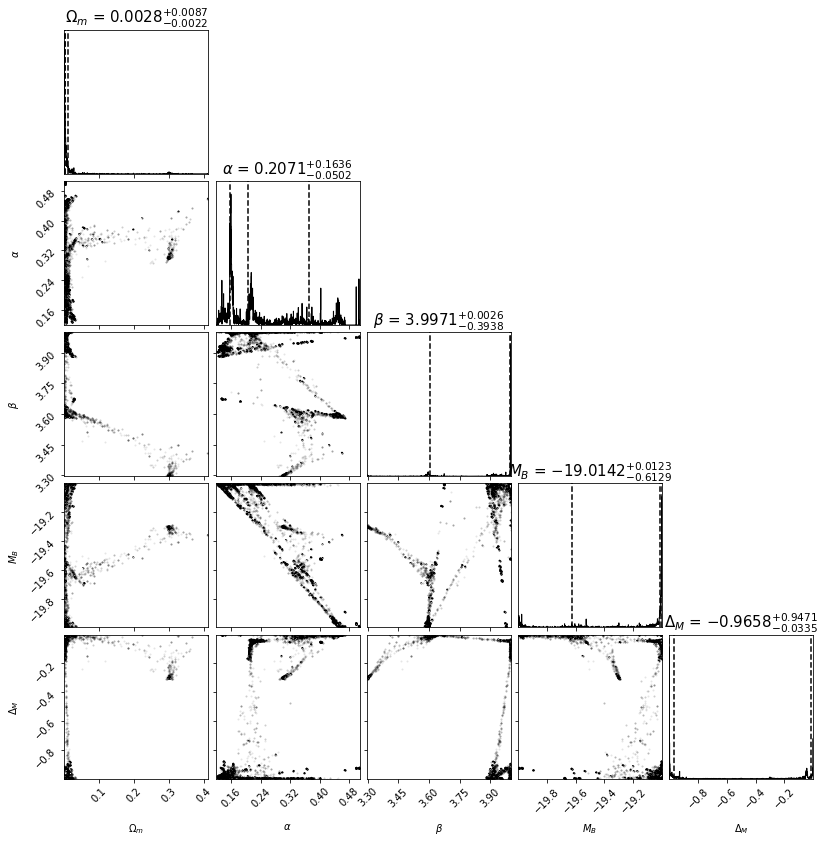

In [17]:

flat_samples = sampler2.get_chain(discard=1, thin=1, flat=True)    #flat=True
fig = corner.corner(
    flat_samples,
    bins = 200,
    hist_bin_factor = 5,
    labels=[r"$\Omega_m$", r"$\alpha$", r"$\beta$", r"$M_{B}$", r"$\Delta_M$"],
    quantiles = [0.16, 0.5, 0.84],
    title_fmt = '.4f',
    show_titles = True, title_kwargs={"fontsize": 15}
    

);

In [19]:
from IPython.display import display, Math
labels = [r"\Omega_m", r"\alpha",r"\beta",r"M_{B}",r"\Delta_M"]
res = np.zeros(ndim2)
for i in range(ndim2):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    res[i] = mcmc[1]
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

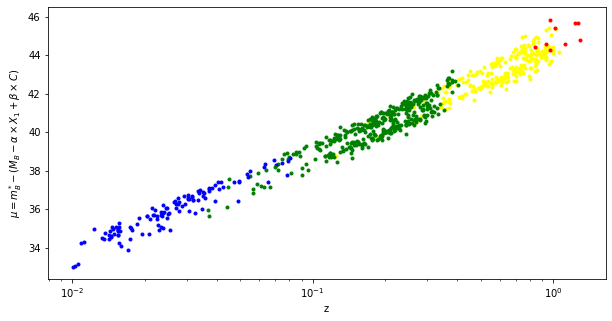

In [21]:
plt.figure(figsize=(10,5))
for i in range(740):
    if conjunto[i] == 3:
        plt.plot(z[i], m_b[i] - (res[3] + res[4]*par_masa[i] - res[1]*x_1[i] + res[2]*C[i]), '.', color = 'blue')
    elif conjunto[i] == 1:
        plt.plot(z[i], m_b[i] - (res[3] + res[4]*par_masa[i] - res[1]*x_1[i] + res[2]*C[i]), '.', color = 'yellow')
    elif conjunto[i] == 2:
        plt.plot(z[i], m_b[i] - (res[3] + res[4]*par_masa[i] - res[1]*x_1[i] + res[2]*C[i]), '.', color = 'green')
    else:
        plt.plot(z[i], m_b[i] - (res[3] + res[4]*par_masa[i] - res[1]*x_1[i] + res[2]*C[i]), '.', color = 'red')
#plt.plot(datos_ord['z'], datos_ord['mu_stand'], '-', color = 'black');
plt.xscale('log')
plt.xlabel('z')
plt.ylabel(r'$\mu = m_{B}^{*} - (M_{B} - \alpha \times X_{1} + \beta \times C)$');

Ahora lo hacemos para 
lowz + SNLS

In [27]:
counter = 0
counter2 = 0
for i in range(740):
  if data[i,16]==3.:
    counter = 1 + counter
  if data[i,16]==1.:
    counter2 = 1 + counter2 
print(counter,counter2)
counter3=counter+counter2


118 239


In [29]:
lowz_SNLS = np.zeros([counter3,19])

lz_SNLS_its=0
for i in range(counter3):

  if data[i,16]==3 or data[i,16] == 1:
    lowz_SNLS[lz_SNLS_its,0:] = data[i,0:]
    lz_SNLS_its = lz_SNLS_its+1  



In [25]:
N_ = counter3
z = np.zeros(N_)
m_b = np.zeros(N_)
err_m_b = np.zeros(N_)
x_1 = np.zeros(N_)
err_x_1 = np.zeros(N_)
C = np.zeros(N_)
err_C = np.zeros(N_)

masa_estelar = np.zeros(N_)
conjunto = np.zeros(N_)

for i in range(N_):


  z[i] = lowz_SNLS[i][0]
  m_b[i] = lowz_SNLS[i][3]
  err_m_b[i] = lowz_SNLS[i][4]
  x_1[i] = lowz_SNLS[i][5]
  err_x_1[i] = lowz_SNLS[i][6]
  C[i] = lowz_SNLS[i][7]
  err_C[i] = lowz_SNLS[i][8]

  masa_estelar[i] = lowz_SNLS[i][9]
  conjunto[i] = lowz_SNLS[i][16]

In [30]:
err_total = np.zeros(N_)
par_masa = np.zeros(N_)

a = np.zeros((N_, N_*3))
n = np.zeros ((N_*3, 1))
delta_k = np.zeros((N_, N_*3, 3))


masa_aux = np.ones(N_)
diagonal1 = np.zeros((N_, N_))
diagonal2 = np.zeros((N_, N_))
diagonal3 = np.zeros((N_, N_))


for i in range(N_):
    err_aux = err_m_b[i]**2 + err_x_1[i]**2 + err_C[i]**2
    err_total[i] = err_aux

    if masa_estelar[i] >= 10:
        par_masa[i] = 1
    else:
        par_masa[i] = 0

    n[3*i] = m_b[i]
    n[3*i + 1] = x_1[i]
    n[3*i + 2] = C[i]

    for j in range(3*N_):
        for k in range(3):
            if 3*i == j + k:
                delta_k[i][j][k] = 1
            else:
                delta_k[i][j][k] = 0

    for j in range(N_):
        if i == j:
          
            diagonal1[i][j] = ((0.0025)/(z[i]*math.log(10)))**2
            diagonal2[i][j] = (0.055*z[i])**2
            
            if conjunto[i] == 3:
                diagonal3[i][j] = (0.12)**2
            elif conjunto[i] == 1:
                diagonal3[i][j] = (0.11)**2
            elif conjunto[i] == 2:
                diagonal3[i][j] = (0.08)**2
            else:
                diagonal3[i][j] = (0.11)**2

In [35]:
np.shape(c_n)

(2220, 2220)